In [1]:
import collections
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import pandas as pd
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
import re
import emoji
import spacy
from spacy_lefff import LefffLemmatizer, POSTagger
from spacy.language import Language
from collections import OrderedDict
from sklearn.feature_extraction.text import CountVectorizer
import datetime
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


In [2]:
df = pd.read_csv("posts_mamda.csv")
#df = df[500:]

In [3]:
days = ["terminer","dej","read","qu","bon","actually","itbu","amir","kods","dé","année","début","dweck","nan","monday","year","wednesday","bu","meta4","lundi", "mardi", "mercredi", "jeudi", "vendredi", "samedi","dimanche"]
verbs = ["dém","réponse","nshalah","voir","nom","nqué","perdre","chercher","partagerr","aller","decide",
"chose","passer","jour","monsieur","madame","qotd","sma","donne","semaine","journée",
"prendre","temps","réponse""best","ooredoo","amen","naimos","acretio","faire","pouvoir",
"savoir","lire","dire","souhaiter","ien","saa","venir","weekend","number","donner",
"parler","tenir","Connaitre"," Demander","sortir"]

In [4]:
@Language.factory('french_lemmatizer')
def create_lemmatizer(nlp, name):
    return LefffLemmatizer()   
def replace_word(text, findWord, replaceWord):
    return ' '.join(replaceWord if word == findWord else word for word in text.split(' '))

In [5]:
nlp = spacy.load('fr_core_news_md')
nlp.add_pipe('french_lemmatizer', name='lefff')  
def replace_lemma(text):  
    doc = nlp(text)
    for d in doc:
        if(d.pos_ != "PROPN" and d.pos_ != "NUM" and d.pos_ != "AUX" and d.pos_ !='DET' and d.pos_ !='PRON' and d.pos_ !='ADJ' and d.pos_ !='ADV'):
            text = replace_word(text, d.text, d.lemma_)
        else:
            text = replace_word(text, d.text, '')        
    return text 

In [6]:
def _remove_emoji(string):
    return emoji.get_emoji_regexp().sub(u'', string)

final_stopwords_list = list(fr_stop) + list(en_stop)+days+verbs
def custom_stopwords(text):
    #common_words    
    text = " ".join([w for w in str(text).split() if w.lower() not in final_stopwords_list])
    #HTML TAGS
    text = re.sub(r'<.*?>', '', text)
    #links
    text = re.sub("https?:\/\/.*[\r\n]*", "", text)  
    #alpha_numeric
    text = re.sub(r'[^a-zA-Z0-9 àâäèéêëîïôœùûüÿçÀÂÄÈÉÊËÎÏÔ\'ŒÙÛÜŸÇ]+', '', text)
    # remove emojis
    text = _remove_emoji(text)
    #remove duplicate space
    clear_text = " ".join(text.split())
    
    return clear_text

In [7]:
def remove_stop_after_lemm(text):
    text = " ".join([w for w in text.split() if w.lower() not in final_stopwords_list])
    return text

In [8]:
def prepare():
    global df
    df["body"] = df["body"].apply(custom_stopwords)
    df = df[df['body'].map(len)>1]
    df["body"] = df["body"].apply(replace_lemma)
    df["body"] = df["body"].apply(remove_stop_after_lemm)    
prepare()    

In [9]:
data = df["body"].values  
#embeddings
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data) 

/home/emna/.local/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


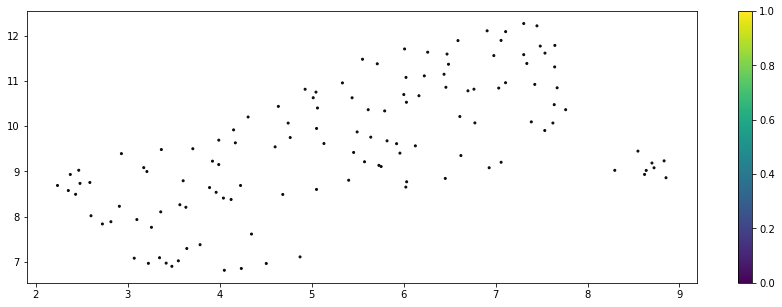

In [10]:
umap_embeddings = umap.UMAP(n_neighbors=8, 
                        n_components=2, 
                        metric='cosine').fit_transform(embeddings)
LABEL_COLOR_MAP = dict()
result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
fig, ax = plt.subplots(figsize=(15, 5))
list_colors = ["#0a0a0a"]
lista=list(set(result.x.values))
for i in lista:
    LABEL_COLOR_MAP[i]="#0a0a0a"
label_color = [LABEL_COLOR_MAP[l] for l in result.x.values]
plt.scatter(result.x, result.y,c=label_color, cmap=label_color, s=4)
plt.colorbar()

In [12]:
# umap is a dimensionality reduction algorithm
umap_embeddings_1 = umap.UMAP(n_neighbors=8, 
                        n_components=3, 
                        metric='cosine').fit_transform(embeddings)

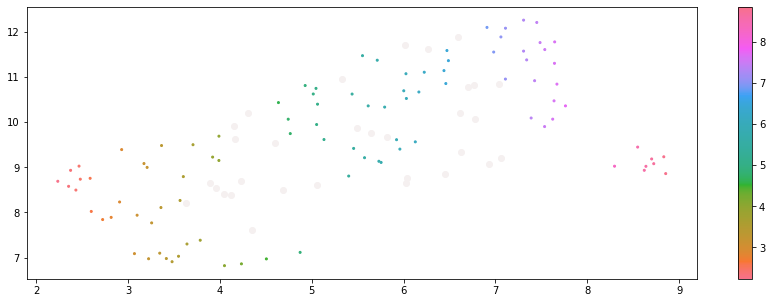

In [20]:
#Clustering
cluster = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1,
                          metric='euclidean',                      
                          cluster_selection_method='leaf').fit(umap_embeddings_1)
result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
result['labels'] = cluster.labels_
# Visualize clusters
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
fig, ax = plt.subplots(figsize=(15, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#f5f0f0')
# LABEL_COLOR_MAP = dict()
# list_colors = ["#42d419","#F1602D","#2DF1C0","#2d99f1","#CB8E9F","#dc8e1e","#095225","#DC341E","#DC1E7D"]
# lista=list(set(clustered.labels.values))
# for i,j in zip(lista,list_colors):
#     LABEL_COLOR_MAP[i]=j
# label_color = [LABEL_COLOR_MAP[l] for l in clustered.labels.values]
plt.scatter(clustered.x, clustered.y, c=clustered.x,  cmap=cmap, s=4)
plt.colorbar()

In [ ]:
#Clustering
cluster = hdbscan.HDBSCAN(min_cluster_size=2,
                          metric='euclidean',                      
                          cluster_selection_method='leaf').fit(umap_embeddings_1)

